In [1]:
!pip install

ERROR: You must give at least one requirement to install (see "pip help install")


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sovitrath/cropped-face-keypoint-dataset-68-landmarks")

print("Path to dataset files:", path)

100%|██████████| 22.5M/22.5M [00:02<00:00, 11.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sovitrath/cropped-face-keypoint-dataset-68-landmarks/versions/1


In [3]:
import os
print(os.listdir(path))


['new_data']


In [4]:
import os
data_path = os.path.join(path, 'new_data')
print(os.listdir(data_path))


['test.csv', 'test', 'training', 'training.csv']


In [5]:
import pandas as pd

# Load and inspect the training csv
train_csv_path = os.path.join(data_path, 'training.csv')
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,1.758499,31.731644,3.758499,39.731644,5.758499,43.731644,9.758499,52.731644,12.758499,...,39.758499,52.731644,46.758499,50.731644,39.758499,52.731644,37.758499,55.731644,33.758499,55.731644
1,Lincoln_Chafee_52.jpg,1.204296,29.626198,3.204296,37.626198,5.204296,46.626198,7.204296,54.626198,11.204296,...,45.204296,68.626198,54.204296,66.626198,45.204296,68.626198,43.204296,68.626198,39.204296,68.626198
2,Valerie_Harper_30.jpg,8.547745,33.183155,8.547745,41.183155,8.547745,50.183155,8.547745,58.183155,10.547745,...,31.547745,69.183155,38.547745,72.183155,29.547745,69.183155,27.547745,69.183155,25.547745,69.183155
3,Angelo_Reyes_22.jpg,61.000000,80.000000,58.000000,95.000000,58.000000,108.000000,58.000000,120.000000,58.000000,...,98.000000,136.000000,107.000000,139.000000,95.000000,139.000000,91.000000,139.000000,85.000000,136.000000
4,Kristen_Breitweiser_11.jpg,9.384323,51.899231,9.384323,61.899231,11.384323,70.899231,13.384323,78.899231,18.384323,...,43.384323,74.899231,54.384323,75.899231,43.384323,77.899231,39.384323,79.899231,35.384323,79.899231


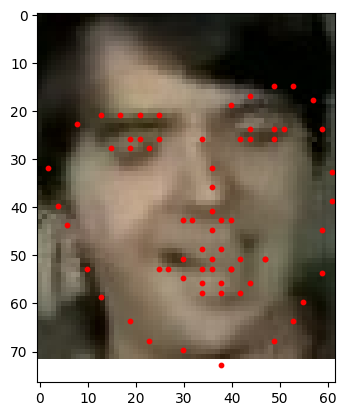

In [6]:
import cv2
import matplotlib.pyplot as plt

# Select the first image and its landmarks
image_name = train_df.iloc[0, 0]
image_path = os.path.join(data_path, 'training', image_name)

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

# Extract landmarks (flatten the coordinates to 2D)
landmarks = train_df.iloc[0, 1:].values.reshape(-1, 2)  # Reshape into (68, 2)

# Plot the image and landmarks
plt.imshow(image)
plt.scatter(landmarks[:, 0], landmarks[:, 1], c='red', s=10)  # Plot landmarks
plt.show()

In [7]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Function to normalize the landmarks (center and scale to [0, 1])
def normalize_landmarks(landmarks):
    # Find the center of the face (average of all landmarks)
    center = np.mean(landmarks, axis=0)

    # Shift all landmarks so the center is at the origin
    landmarks_centered = landmarks - center

    # Scale the landmarks (optional, for better performance)
    # Calculate the norm along axis=1, ensuring it returns an array even for single elements
    # Convert landmarks_centered to float64 before applying sqrt
    distances = np.sqrt(np.sum(landmarks_centered.astype(np.float64)**2, axis=1, keepdims=True))
    max_distance = np.max(distances) if distances.size > 0 else 1.0  # Handle empty distances
    landmarks_normalized = landmarks_centered / max_distance

    return landmarks_normalized, center, max_distance

# Function to load and preprocess images and landmarks
def preprocess_data(df, image_folder):
    images = []
    landmarks = []

    for i in range(len(df)):
        # Load image
        image_name = df.iloc[i, 0]
        image_path = os.path.join(image_folder, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

        # Resize the image
        image = cv2.resize(image, (128, 128))  # Resize to 128x128

        # Extract and normalize landmarks
        landmark_coords = df.iloc[i, 1:].values.reshape(-1, 2)  # 68 landmarks, each with x, y
        landmark_coords, _, _ = normalize_landmarks(landmark_coords)  # Normalize

        images.append(image)
        landmarks.append(landmark_coords.flatten())  # Flatten landmarks to (136,)

    images = np.array(images) / 255.0  # Normalize images to [0, 1]
    landmarks = np.array(landmarks)

    return images, landmarks

# Load and preprocess the training data
image_folder = os.path.join(data_path, 'training')
X, y = preprocess_data(train_df, image_folder)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (2750, 128, 128, 3)
Validation set shape: (688, 128, 128, 3)


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def build_encoder(input_shape=(128, 128, 3), latent_dim=128):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze base for now

    # Create encoder model
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(latent_dim, activation='relu')(x)

    encoder = models.Model(inputs, x, name="Encoder")
    return encoder


In [9]:
# 1. Build the encoder
encoder = build_encoder()

# 2. Pick a sample image
sample_image = X[0]  # X was your preprocessed training set
sample_image = tf.expand_dims(sample_image / 255.0, axis=0)  # Normalize & add batch dimension

# 3. Pass through encoder
latent_vector = encoder(sample_image)

# 4. Print the results
print("Latent vector shape:", latent_vector.shape)
print("Latent vector (first 10 values):", latent_vector.numpy()[0][:10])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Latent vector shape: (1, 128)
Latent vector (first 10 values): [0.7394681  1.0859046  0.28087676 0.4980672  0.         0.93913233
 0.         0.15506211 0.42888576 0.4785907 ]


In [10]:
def build_decoder(latent_dim=128, output_dim=136):  # 68 points × 2
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(output_dim, activation='linear')(x)  # Predicts (x, y) pairs
    decoder = models.Model(inputs, x, name="Decoder")
    return decoder


In [11]:
decoder = build_decoder()

# Connect encoder and decoder
inputs = layers.Input(shape=(128, 128, 3))
latent = encoder(inputs)
outputs = decoder(latent)

model = models.Model(inputs, outputs, name="NeuralRenderingModel")
model.summary()


Model: "NeuralRenderingModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder (Functional)                 │ (None, 128)                 │       2,421,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder (Functional)                 │ (None, 136)                 │         234,376 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,656,328 (10.13 MB)

 Trainable params: 398,344 (1.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=['mae']
)


In [13]:
y_flat = y.reshape((y.shape[0], -1)).astype('float32')


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_flat, test_size=0.2, random_state=42
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32
)


Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - loss: 0.0466 - mae: 0.1408 - val_loss: 0.0099 - val_mae: 0.0753
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0090 - mae: 0.0716 - val_loss: 0.0083 - val_mae: 0.0685
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0080 - mae: 0.0671 - val_loss: 0.0078 - val_mae: 0.0664
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0072 - mae: 0.0638 - val_loss: 0.0074 - val_mae: 0.0647
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0064 - mae: 0.0604 - val_loss: 0.0074 - val_mae: 0.0646
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0060 - mae: 0.0583 - val_loss: 0.0070 - val_mae: 0.0624
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0054 - mae: 0.0551 - val_loss: 0.0075 - val_mae: 0.0647
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0049 - mae: 0.0527 - val_loss: 0.0067 - val_mae: 0.0608
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0

In [15]:
from tensorflow.keras import layers, models

def build_image_decoder(latent_dim=128, output_shape=(128, 128, 3)):
    # Input for the decoder (latent keypoints)
    inputs = layers.Input(shape=(latent_dim,))

    # Dense layers to learn the features from the keypoints
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dense(512, activation='relu')(x)

    # Upsampling layer to expand to image size
    x = layers.Dense(128 * 128 * 3, activation='sigmoid')(x)  # sigmoid for pixel values [0,1]
    x = layers.Reshape((128, 128, 3))(x)  # Reshape to (128, 128, 3) for RGB image

    # Decoder model
    decoder = models.Model(inputs, x, name="ImageDecoder")
    return decoder

# Build the image decoder
image_decoder = build_image_decoder()
image_decoder.summary()


Model: "ImageDecoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 49152)               │      25,214,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,379,584 (96.82 MB)

 Trainable params: 25,379,584 (96.82 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Assuming we already have `encoder` and `image_decoder` from previous steps

# Input for the full model
inputs = layers.Input(shape=(128, 128, 3))

# Encoder to get latent features (keypoints)
latent = encoder(inputs)

# Decoder to reconstruct the image from the latent features
reconstructed_image = image_decoder(latent)

# Full model that encodes and decodes an image
full_model = models.Model(inputs, reconstructed_image, name="NeuralRenderingModel")

# Summary of the model
full_model.summary()


Model: "NeuralRenderingModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder (Functional)                 │ (None, 128)                 │       2,421,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ImageDecoder (Functional)            │ (None, 128, 128, 3)         │      25,379,584 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,801,536 (106.05 MB)

 Trainable params: 25,543,552 (97.44 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Compile the model
full_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = full_model.fit(
    X_train, X_train,  # We are reconstructing the input image
    validation_data=(X_val, X_val),
    epochs=30,         # Adjust epochs as needed
    batch_size=32      # Adjust batch size if necessary
)


Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - loss: 0.0458 - mae: 0.1713 - val_loss: 0.0375 - val_mae: 0.1495
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.0342 - mae: 0.1443 - val_loss: 0.0336 - val_mae: 0.1413
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0313 - mae: 0.1371 - val_loss: 0.0310 - val_mae: 0.1364
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0288 - mae: 0.1308 - val_loss: 0.0305 - val_mae: 0.1348
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0272 - mae: 0.1267 - val_loss: 0.0291 - val_mae: 0.1319
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0258 - mae: 0.1233 - val_loss: 0.0286 - val_mae: 0.1301
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0249 - mae: 0.1209 - val_loss: 0.0278 - val_mae: 0.1276
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0237 - mae: 0.1177 - val_loss: 0.0276 - val_mae: 0.1278
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


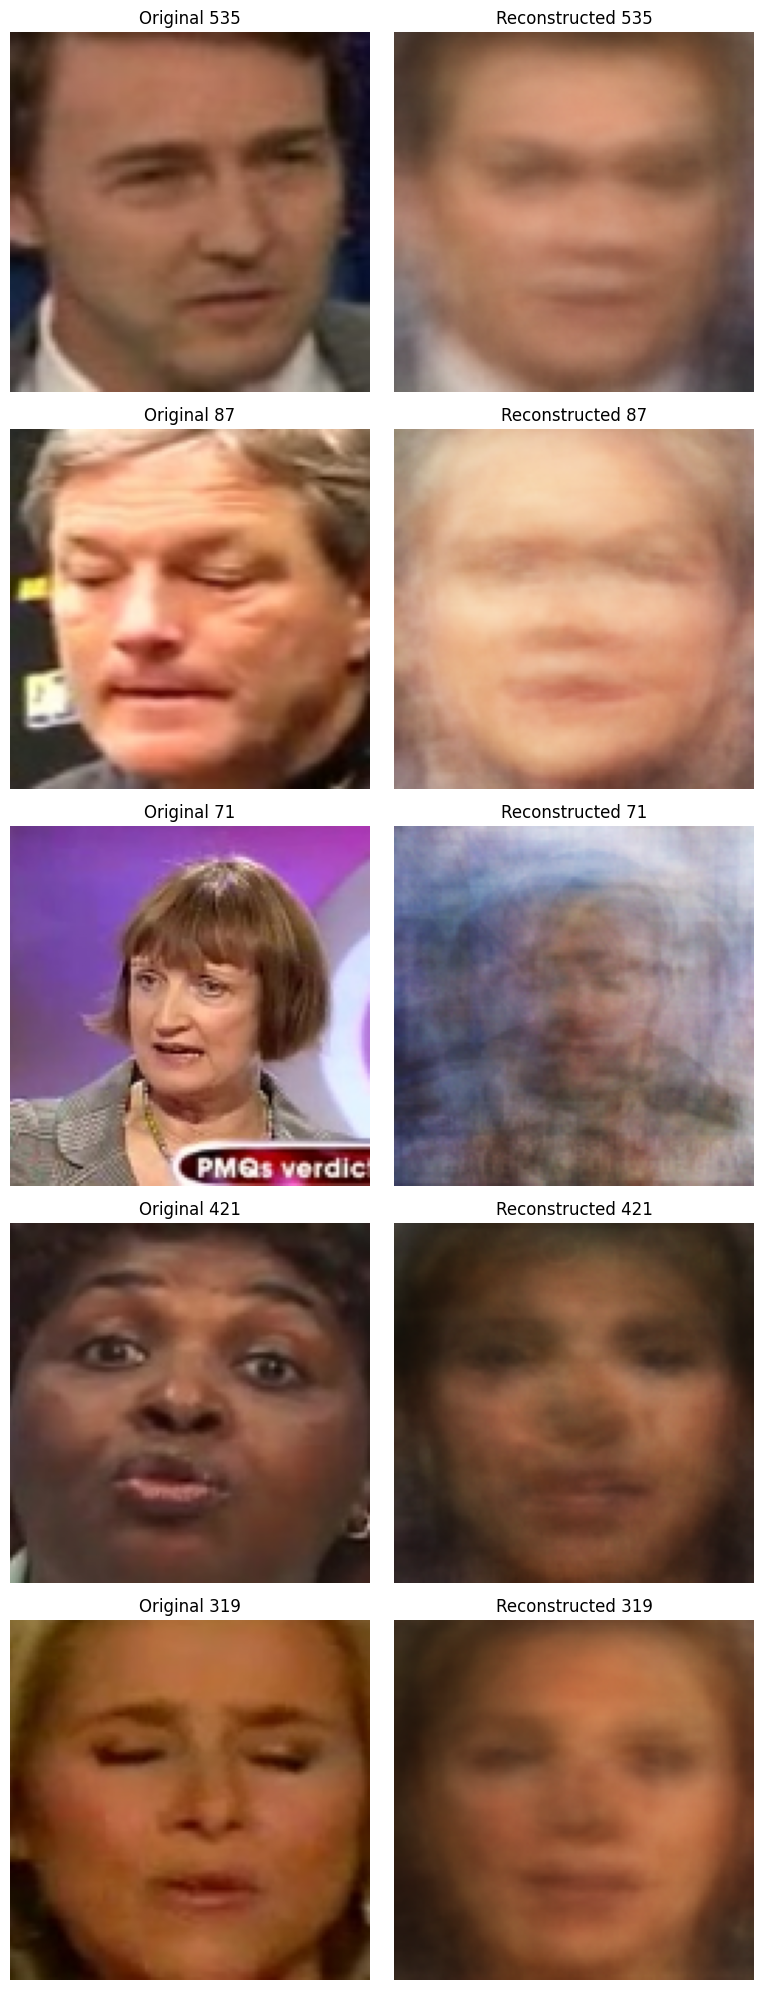

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize original vs reconstructed images
def visualize_reconstruction(model, X_val, num_samples=5):
    # Choose random samples from the validation set
    random_indices = np.random.choice(len(X_val), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))

    for i, idx in enumerate(random_indices):
        original_image = X_val[idx]  # Original image
        reconstructed_image = model.predict(np.expand_dims(original_image, axis=0))[0]  # Reconstructed image

        # Plot original and reconstructed side by side
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f"Original {idx}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(reconstructed_image)
        axes[i, 1].set_title(f"Reconstructed {idx}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize results
visualize_reconstruction(full_model, X_val, num_samples=5)
